### calculates and writes out z-ratio from obs

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import pop_tools
import cartopy
import cartopy.crs as ccrs

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [2]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT

### necessary variables to calculate the Z-ratio (Stock & Dunne, 2010)

##### get COPEPOD on POP grid

In [48]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file)
#ds_copepod['copepod_C']=ds_copepod.copepod_C

In [49]:
ds_copepod = ds_copepod.rename({'lat':'nlat'})
ds_copepod = ds_copepod.rename({'lon':'nlon'})

##### get NPP on POP grid

In [50]:
file = '/glade/work/kristenk/satellite_data/POP_regrid/NPP_3methodmean_mean2003-2017_POPgrid.nc'
ds_NPP=xr.open_dataset(file,decode_times=False,decode_coords=False)
#units are gC m-2 y-1
ds_NPP['NPP']=ds_NPP.NPP/365. #convert to gC/m2/d

##### get CHL from MODIS on POP grid

In [51]:
file = '/glade/work/kristenk/satellite_data/POP_regrid/MODIS_meanCHL2003to2018_mgm3_x1POPgrid.nc'
ds_CHL=xr.open_dataset(file,decode_times=False,decode_coords=False)
#units are mg/m3

##### get SST

In [52]:
file = '/glade/work/kristenk/satellite_data/POP_regrid/MODIS_meanSST2002to2017_x1POPgrid.nc'
ds_SST=xr.open_dataset(file,decode_times=False,decode_coords=False)

### First convert surface CHL to mean euphotic zone chlorophyll

#### reference: Morel & Berthon (1989)

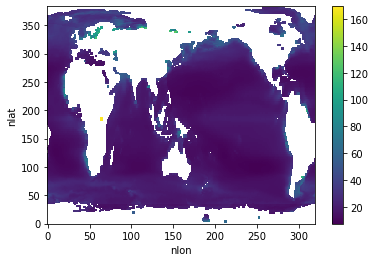

In [53]:
chl_proc=np.full((384, 320), np.nan)


chl_hilat = ds_CHL.CHL.where(np.absolute(lats) >= 60)
chl_lolat = ds_CHL.CHL.where(np.absolute(lats) < 60)

chl_hilat = 37.9 * chl_hilat**0.548
chl_lolat = 40.6 * chl_lolat**0.459

chl_hilat = np.asarray(chl_hilat)
chl_lolat = np.asarray(chl_lolat)

chl_proc[~np.isnan(chl_hilat)] = chl_hilat[~np.isnan(chl_hilat)]
chl_proc[~np.isnan(chl_lolat)] = chl_lolat[~np.isnan(chl_lolat)]

chl_proc=xr.DataArray(chl_proc)

chl_proc=chl_proc.rename({'dim_0':'nlat'})
chl_proc=chl_proc.rename({'dim_1':'nlon'})
chl_proc.plot();

In [54]:
Zeu = 200.0 * chl_proc**(-0.293) # when Zeu > 102 m / Ctot > 10 mg
condition = chl_proc <= 10

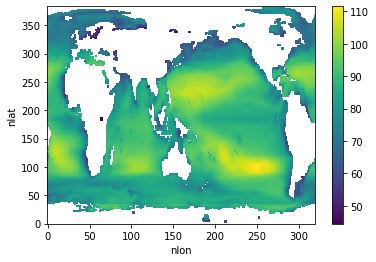

In [55]:
Zeu.plot()

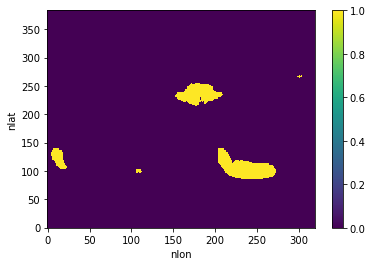

In [56]:
condition.plot()

In [57]:
Zeu.values[condition.values] = 568.2 * chl_proc.values[condition.values]**(-0.746)

In [58]:
ds_CHL['Chl_Zeu'] = chl_proc / Zeu 

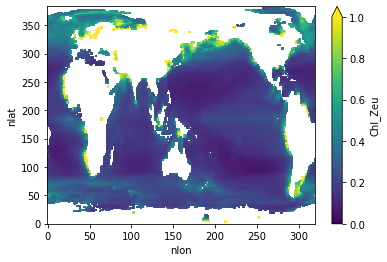

In [59]:
ds_CHL['Chl_Zeu'].plot(vmin=0, vmax=1)

### Now calculate the mesozooplankton growth rate

In [60]:
mz_weight = 10 # micrograms C / ind

mz_growth = 0.0186 * ds_SST.SST.values - 0.288 * np.log10(mz_weight) + 0.417 * np.log10(ds_CHL['Chl_Zeu'].values) - 1.209
mz_growth = 10**mz_growth

In [61]:
mz_growth = xr.DataArray(mz_growth)
mz_growth=mz_growth.rename({'dim_0':'nlat'})
mz_growth=mz_growth.rename({'dim_1':'nlon'})

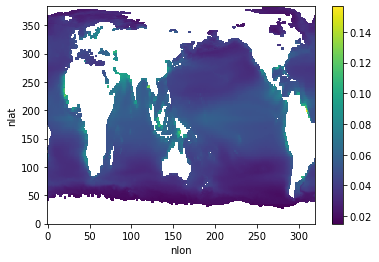

In [62]:
mz_growth.plot()

In [63]:
mz_biomass=ds_copepod.copepod_C * 0.001 * 200. #convert from mgC/m3 to gC/m3, then integrate over top 200m to get gC/m2

In [64]:
zoo_prod = mz_biomass * mz_growth

#### Finally, compute the z-ratio

In [65]:
z_ratio = zoo_prod / ds_NPP.NPP

In [66]:
ds_copepod.copepod_C

<xarray.DataArray 'copepod_C' (nlat: 384, nlon: 320)>
dask.array<zarr, shape=(384, 320), dtype=float64, chunksize=(192, 160), chunktype=numpy.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  Total Carbon Mass
    units:      mg-C m$^{-3}$

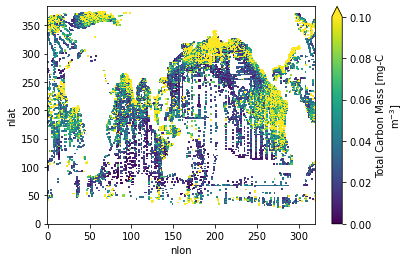

In [67]:
z_ratio.plot(vmin=0,vmax=0.1)

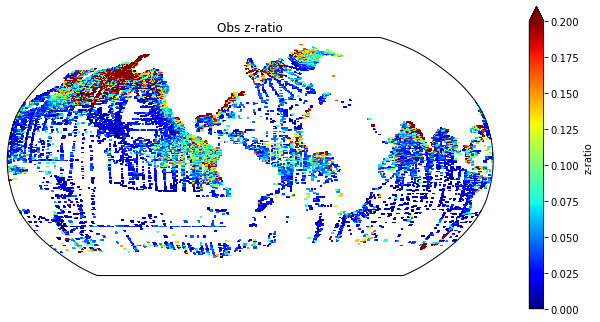

In [69]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Obs z-ratio', fontsize=12)

pc=ax.pcolormesh(lons, lats, z_ratio, cmap='jet',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='z-ratio');

### write out data

In [70]:
ds_out = xr.Dataset()
ds_out['z_ratio']= z_ratio
file='/glade/work/kristenk/z-ratio/z_ratio_POPgrid.nc'
ds_out.to_netcdf(file)